## 1. Introducción

In [7]:
#Lectura de Datos

library(dataseries)
library(forecast)
library(lmtest)
library(car)
library(TSA)
library(FitAR)
library(timsac)
library(xts)

In [8]:
D <- dataseries::ds("TOU.OVR.D")
x = D$TOU.OVR.D
fechas = D$time
n1=which(fechas=="2005-01-01")
n2=which(fechas=="2017-06-01")
x = D$TOU.OVR.D[n1:n2]
fechas = fechas[n1:n2]
np = length(x)

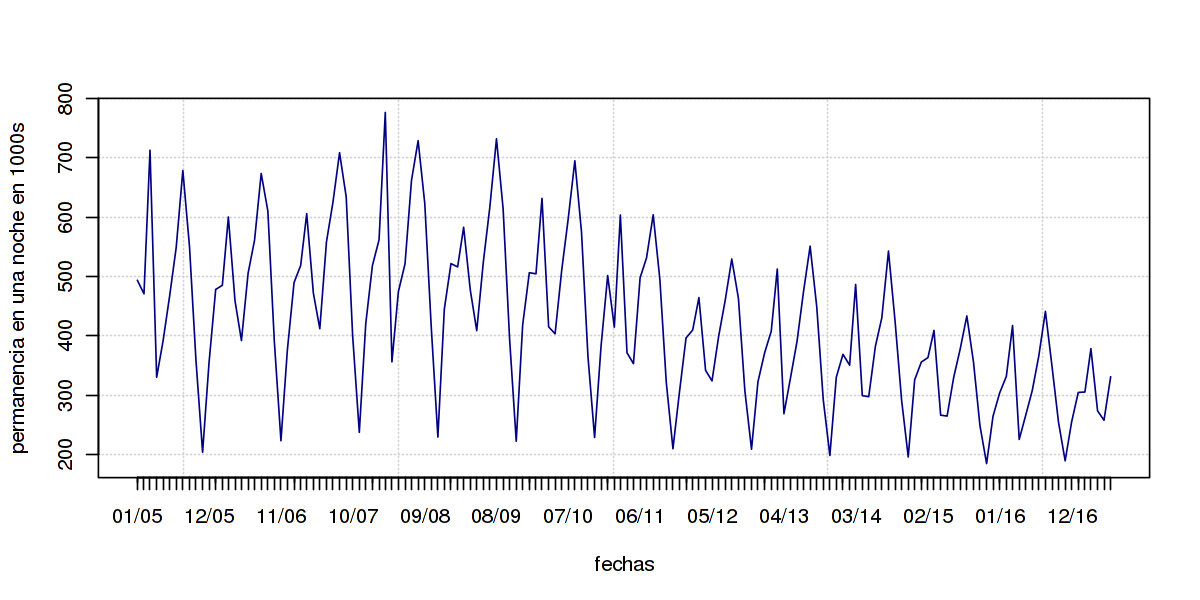

In [9]:
options(repr.plot.width=10, repr.plot.height=5)

ejex.mes = seq(fechas[1],fechas[np], "months")
ejex.año = seq(fechas[1],fechas[np], "years")
plot(fechas,x, xaxt="n", panel.first = grid(),type='l',ylab='permanencia en una noche en 1000s', lwd = 1, col = 'navy')
axis.Date(1, at=ejex.mes, format="%m/%y")
axis.Date(1, at=ejex.año, labels = FALSE, tcl = -0.2)

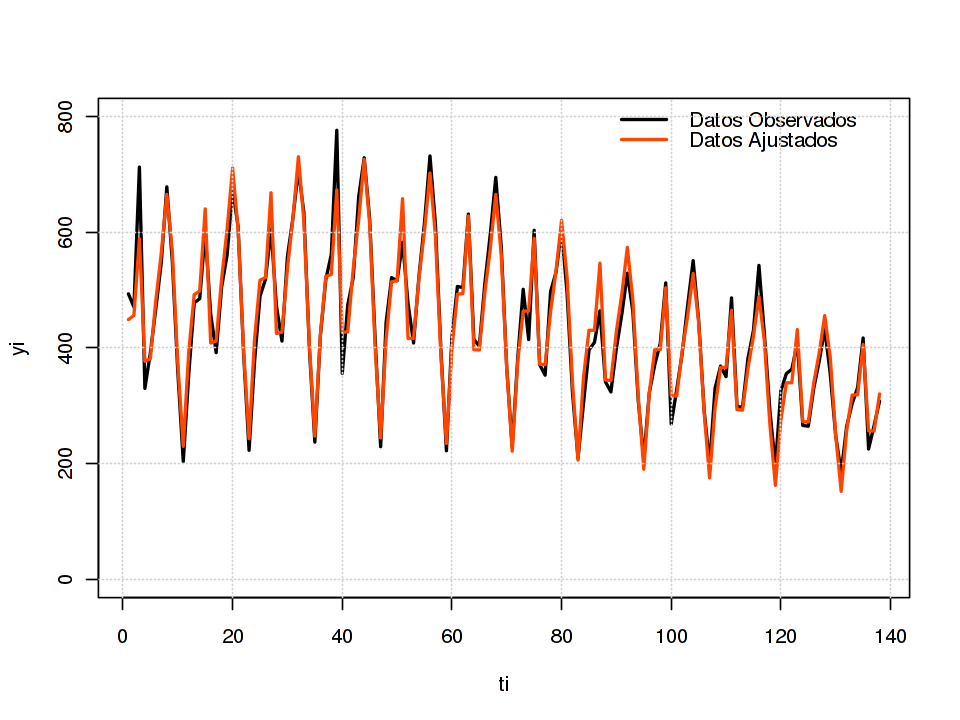

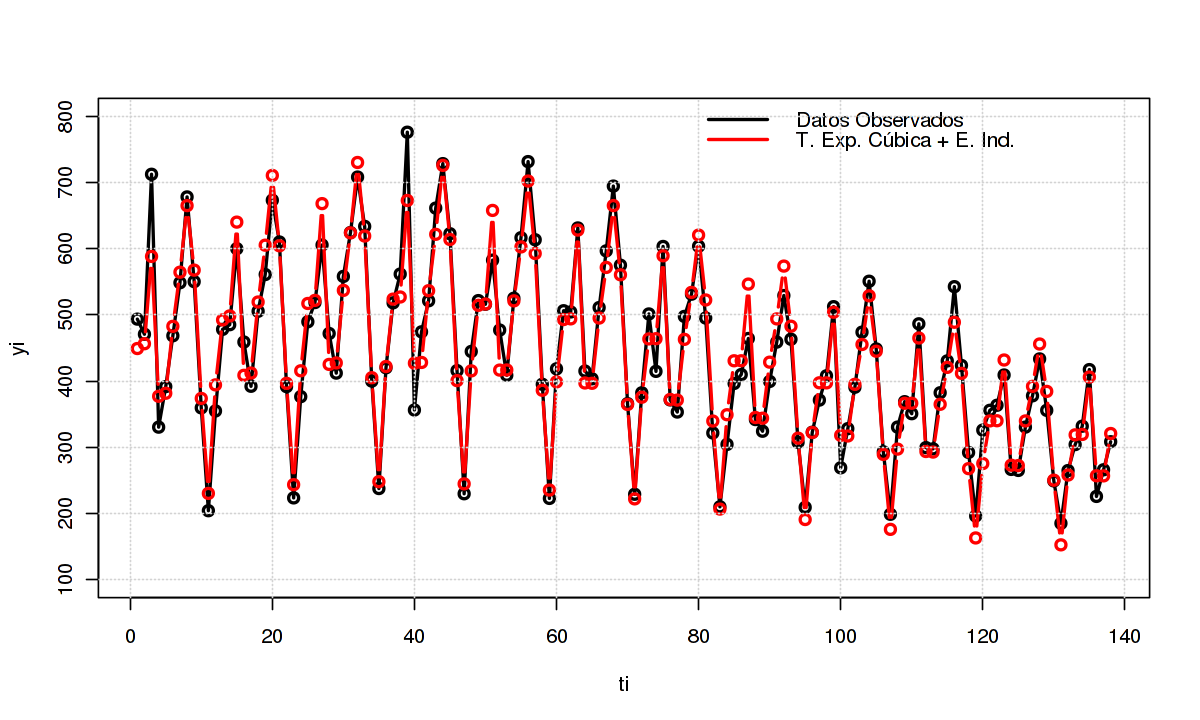

In [10]:
y = ts(x,frequency=12,start=c(2005,1),end=c(2017,6))

#Separacion datos de entrenamiento y de validacion cruzada
#Se separa un año de datos

m = 12
n = length(y)
yi = ts(y[1:(n-m)],frequency=12)
yf = ts(y[(n-m+1):n],frequency=12)

lyi = log(yi) #modelo log-lin

#Tendencia: Lineal + Estacionalidad: Indicadoras

ti = seq(1,length(yi))
ti2 = ti*ti
ti3 = ti2*ti

It = seasonaldummy(yi)

#Tendencia: log cubico + Estacionalidad: Indicadoras
mod8 = lm(lyi ~ ti + +ti2 + ti3 + It)

# El modelo exponencial-cubico-estacional - Indicadoras

T = length(yi)
Xt = cbind(rep(1,T),ti,ti2,ti3,It)
Ds = data.frame(yi,Xt)
theta.0 = mod8$coefficient
mod9 = nls(yi~exp(Xt%*%theta), data=Ds, start= list(theta=theta.0))

yhat9 = fitted(mod9)
r9 <- yi-yhat9
#par(mfrow=c(2,2))
#plot(ti,r9,type='o',ylab='residuo')
#abline(h=0,lty=2)
#plot(density(r9),xlab='x',main= '')
#qqnorm(r9)
#qqline(r9,col=2)

par(mfrow=c(1,1))

options(repr.plot.width=8, repr.plot.height=6)
plot(ti, yi, type = "l", lwd = 2, ylim = c(0,800))
lines(ti, yhat9, col = "orangered1", lwd = 2)
legend( "topright",                              # posicion
        c("Datos Observados","Datos Ajustados"),                 # texto
        lwd = c(2, 2),                          # grosor lineas
        col = c('black','orangered1'),                 # color lineas
        bty = "n")                              # sin caja alrededor de la leyenda
grid()

par(mfrow=c(1,1))

options(repr.plot.width=10, repr.plot.height=6)
plot(ti,yi,type='o', ylim = c(100,800), lwd=2)
lines(ti,yhat9,col = 'red',type='b', lwd =2)

legend("topright", 
    c("Datos Observados","T. Exp. Cúbica + E. Ind."), 
    col = c("black","red"),
    lty=1,
    bty='n', 
    #cex=.75,
    lwd = c(2, 2), )
grid()



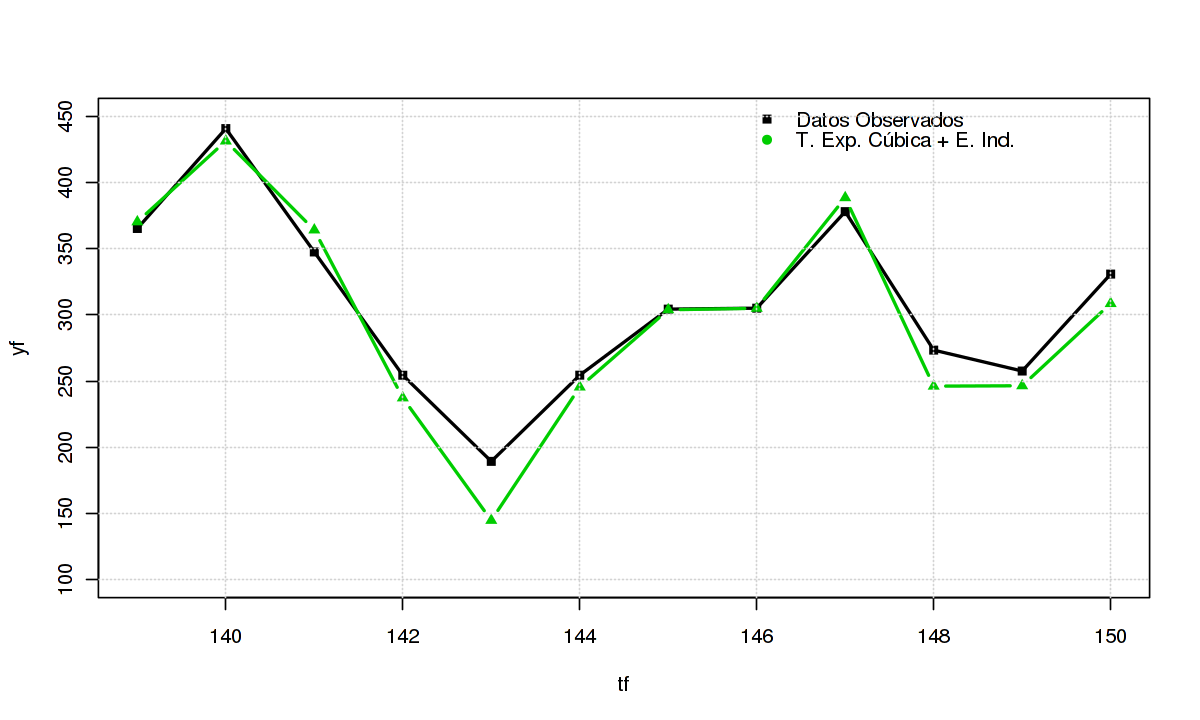

In [11]:
T = length(yi)
Itf = seasonaldummy(yi,m)
tf = seq(T+1,T+m,1)

tf2 = tf*tf
tf3 = tf2*tf
Xtf = cbind(rep(1,m),tf,tf2,tf3,Itf)

pron3 = predict(mod9,data.frame(Xt = I(Xtf)))

par(mfrow=c(1,1))
plot(tf,yf, type = 'o', pch = 15, ylim=c(100,450), lwd=2)
lines(tf,pron3, type = 'b', pch = 17,col='green3', lwd=2 )

legend("topright", c("Datos Observados", "T. Exp. Cúbica + E. Ind."),  bty='n', pch = c(15, 16, 17), 
       col = c("black","green3"))

grid()

Contextualice la serie: definición, frecuencia, perı́odo de los datos, fuente
de los datos (solo si está disponible). Describa el modelo que mejor pronosticó la serie
en el Trabajo No 1. Incluya una gráfica de los pronósticos estructurales versus los datos
observados, para el perı́odo de validación cruzada. Describa el objetivo de su análisis de
acuerdo a los puntos siguientes.

## 2. Pruebas de incorrelación ##

Realice las Pruebas de incorrelación con los residuos
estructurales: Ljung-Box, Durbin-Watson (cuando sea posible), y la gráfica de la fac
y la fac parcial con las bandas de Bartlett. Concluya sobre si los residuos son ruido
blanco o no. De ser posible, identifique un AR(p) ó un MA(q) con estas gráficas.



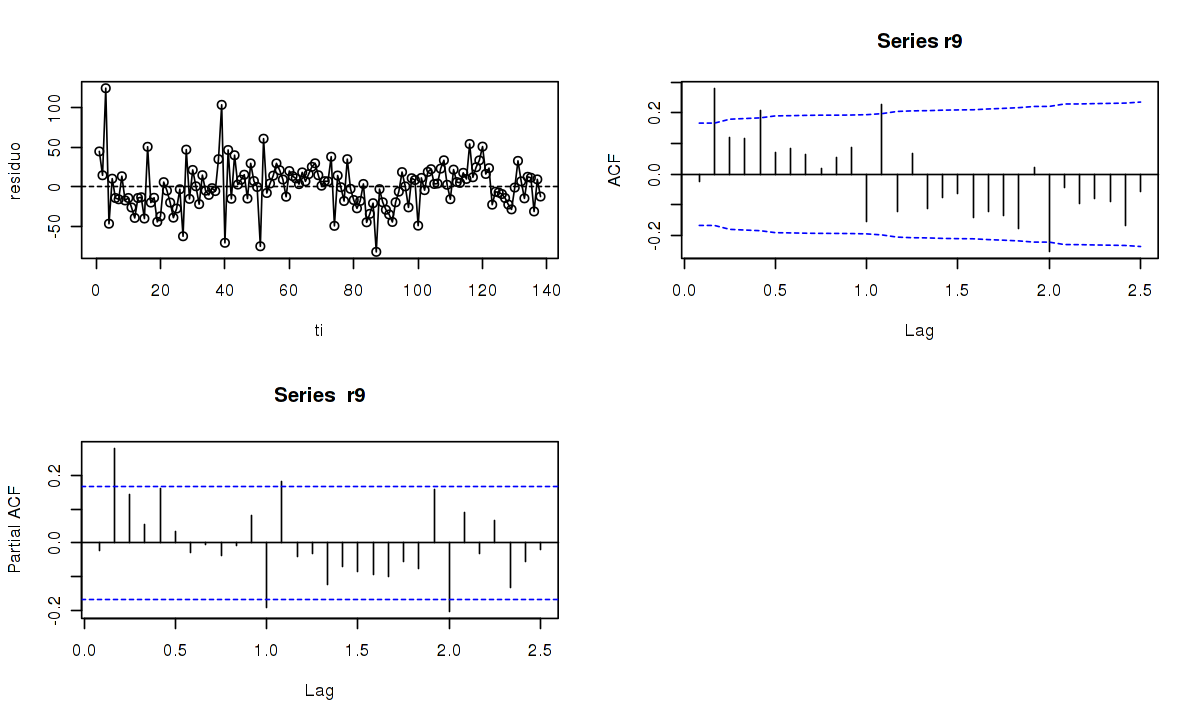

In [12]:
#-------------graficar autocorrelacion (fac)

par(mfrow=c(2,2))
plot(ti,r9,type='o',ylab='residuo')
abline(h=0,lty=2)
acf(r9,30,ci.type="ma")
pacf(r9,30)


In [13]:
cat('Pruebas Box-Ljung')
Box.test(r9, lag = 5 , type =  "Ljung-Box")
Box.test(r9, lag = 15 , type =  "Ljung-Box")
Box.test(r9, lag = 25 , type =  "Ljung-Box")

Pruebas Box-Ljung


	Box-Ljung test

data:  r9
X-squared = 21.708, df = 5, p-value = 0.0005948



	Box-Ljung test

data:  r9
X-squared = 40.372, df = 15, p-value = 0.0003984



	Box-Ljung test

data:  r9
X-squared = 68.957, df = 25, p-value = 5.491e-06


In [14]:
# Se define una nueva serie para agregar el ruido del modelo y poder aplicar DW
     
m_dw <- lm(r9 ~ ti)

#dwtest(m_dw) # de la libreria lmtest
cat('-------------------------------------------------------------------------------------------------------------------')
durbinWatsonTest(m_dw,max.lag = 15) # de libreria car

-------------------------------------------------------------------------------------------------------------------

 lag Autocorrelation D-W Statistic p-value
   1     -0.02645121      2.033631   0.966
   2      0.27874281      1.420686   0.000
   3      0.11643249      1.605692   0.034
   4      0.11450047      1.592067   0.016
   5      0.20484650      1.409328   0.000
   6      0.06643548      1.682556   0.136
   7      0.07913294      1.655257   0.128
   8      0.06130401      1.681354   0.128
   9      0.01538833      1.771043   0.434
  10      0.05284372      1.687167   0.242
  11      0.08517716      1.612608   0.130
  12     -0.15715372      2.083252   0.164
  13      0.22455291      1.317485   0.000
  14     -0.12341638      2.011580   0.274
  15      0.06463627      1.622502   0.286
 Alternative hypothesis: rho[lag] != 0

Comentarios....

- Criterios para aceptacion de la prueba Ljung-Box

$H_{0}: {\epsilon}_t$ ~ $RB(0,{\sigma}^2)$

$H_1:$ no ($H_0$)


<span style="color:blue">Si p-value '<'0.05: Se puede rechazar la hipótesis nula suponiendo un 5% de posibilidades de cometer un error. Entonces se puede asumir que sus valores muestran dependencia el uno del otro.</span>


- Criterios para determinar  AR o MA a partir de la grafica

<span style="color:blue">MA(q): Dado que la gráfica de ACF no termina abrutamente, no es posible determinar que la $ \epsilon_{t}$ se trate de una serie tipo MA(q)</span>

<span style="color:blue">De igual manera su PACF no decrece a cero. (Giraldo p.115)</span>

<span style="color:blue">De acuerdo a las teoria expuesta por (Giraldo p. 129), el modelo expuesto tampo seria un AR(p) puro ya la grafica de autocorrelacion parcial se tienen resagos que siguen saliendo de las bandas de Bartlett, sugiriendo que se debe seguir buscando otro tipo de modelo</span>


- Criterios para aceptacion de la prueba Durbin-Watson

<span style="color:blue"> Se aplica DWG ya se tiene un modelo diferente a un AR(1), y tambien segun (Giraldo, p.99) que d menor a 2 indica posible autocorrelación positiva en la serie. Para la mayoria de los valores de los lag evaluados, este valor es menor a 2, indicando que se presenta autocorrelacion en esos resagos de la serie.</span>

<span style="color:blue">Como refuerzo de lo anterior, en la tabla de DWG se observa que no se trata de un AR(1) ya que el valor de p para el lag 1 es casi 1, mientras que otros lag son menores que 0.05, mostrando que la autocorrelacion es diferente al primer lag.
</span>

## 3. Identificación ##

a) con armasubsets. Identifique un posible modelo ARMA-SARMA mediante la
función armasubsets() de la librerı́a TSA. Recuerde declarar los residuos con
la función ts(et,frequency=), utilizando la misma frecuencia que para la serie
original $Y_t$ . Reporte el modelo.

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“19  linear dependencies found”

Reordering variables and trying again:


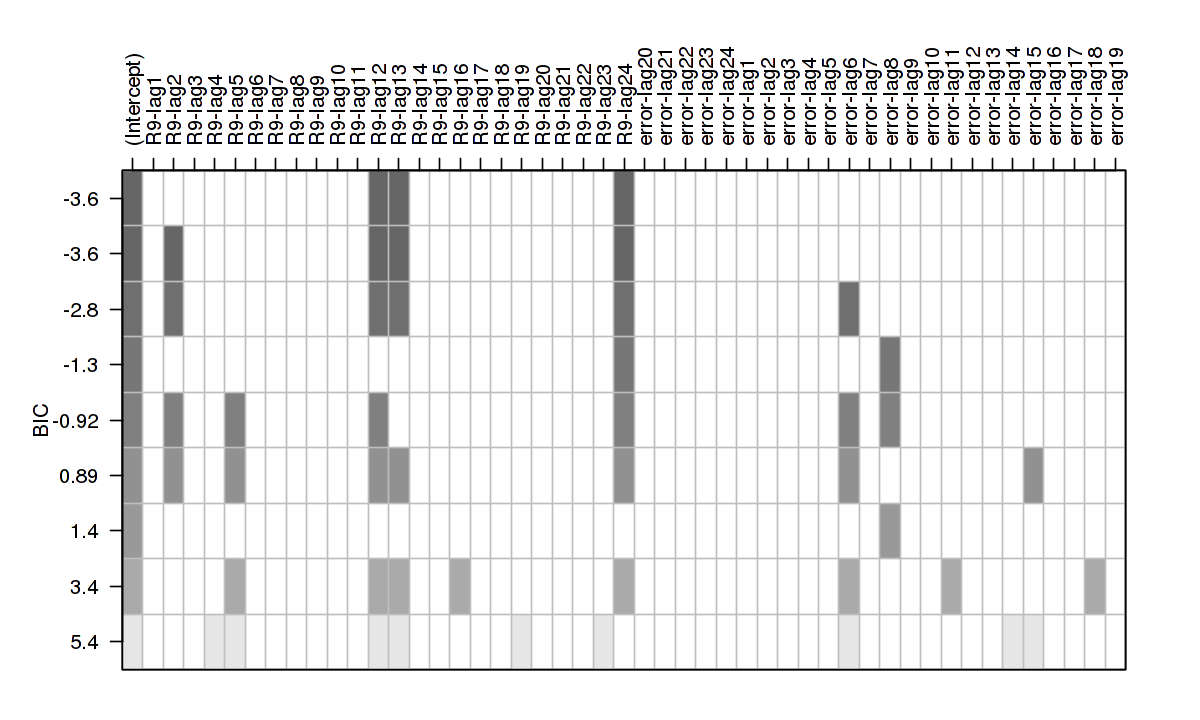

In [35]:
#------------identificador armasubsets

r9ts=ts(r9,frequency = 12)

res=armasubsets(y=r9ts,
nar=24,nma=24,
y.name='R9',
ar.method='ols')

par(mfrow=c(1,1))
plot(res)

Comentarios


b) con SelectModel. Identifique un posible modelo AR(p) para los residuos mediante la función SelectModel() de la librerı́a FitAR. Reporte el orden p.

In [30]:
posmod = SelectModel(r9ts, ARModel=c("AR", "ARz", "ARp"), Criterion="AIC", Best=1)
posmod

modres = FitAR(r9,posmod,MeanMLEQ=TRUE)
modres


[1] 5

Warning message in matrix(c(racf, sdRacf), ncol = 2):
“la longitud de los datos [55] no es un submúltiplo o múltiplo del número de filas [28] en la matriz”Warning message in (ra^2)/(n - (1:lag.max)):
“longitud de objeto mayor no es múltiplo de la longitud de uno menor”

AR(5). MLE.  Mean estimated using MLE
length of series = 138 ,  number of parameters = 6
loglikelihood = -458.329 ,  AIC = 928.7 ,  BIC =  946.2

In [31]:
#Determinar la frecuencia

find.freq <- function(x)
    {
     n <- length(x)
     spec <- spec.ar(c(x),plot=FALSE)
     if(max(spec$spec)>10) # Arbitrary threshold chosen by trial and error.
        {
            period <- round(1/spec$freq[which.max(spec$spec)])
            if(period==Inf) # Find next local maximum
                {
                    j <- which(diff(spec$spec)>0)
                    if(length(j)>0)
                        {
                            nextmax <- j[1] + which.max(spec$spec[j[1]:500])
                            period <- round(1/spec$freq[nextmax])
                            }
                        else
                        period <- 1
                        }
            }
        else
        period <- 1
    return(period)
}

find.freq(r9)

periodicity(r9)

[1] 2

Monthly periodicity from ene 1 to jun 12 

c) con auto.arima. Identifique un posible modelo ARMA-SARMA mediante la
función auto.arima() de la librerı́a forecast. Aplicar las restricciones: stationary=TRUE,
seasonal=TRUE para obtener un modelo estacionario estacional. 
Use el código siguiente. 
Reporte el modelo.  

In [32]:
auto.arima(r9ts, d=NA, D=NA,max.p=13, max.q=13,max.P=13, max.Q=13,
max.order=12, start.p=2, start.q=2, start.P=1, start.Q=1,
stationary=TRUE, seasonal=TRUE,
ic= "aicc", stepwise=TRUE, trace=FALSE,
approximation=(length(r9ts)>100 | frequency(r9ts)>12)) 

Series: r9ts 
ARIMA(1,0,1)(5,0,0)[6] with zero mean 

Coefficients:
         ar1      ma1     sar1     sar2     sar3     sar4    sar5
      0.8889  -0.7495  -0.0398  -0.3287  -0.0233  -0.3384  0.0129
s.e.  0.0754   0.1028   0.0943   0.0920   0.0943   0.0874  0.0987

sigma^2 estimated as 740.3:  log likelihood=-649.95
AIC=1315.91   AICc=1317.03   BIC=1339.33

d ) con autoarmafit. Identifique un posible modelo ARMA-SARMA mediante la
función autoarmafit() de la librerı́a timsac. Reporte el modelo.

In [20]:
autoarmafit(r9)



Case No. 1

 AR coefficient	Standard deviation
 0.510040	0.171361
 0.288832	0.087741

 MA coefficient	Standard deviation
 0.593364	0.170550

 AIC	925.821094
 Innovation variance	784.753963
 Final gradient	9.099423e-02	6.338224e-03	-6.239671e-03


Case No. 2

 AR coefficient	Standard deviation
 0.821756	0.112749

 MA coefficient	Standard deviation
 0.896426	0.130313
 -0.246629	0.086425

 AIC	927.180652
 Innovation variance	792.523466
 Final gradient	-2.315672e-02	-1.886440e-02	4.600005e-02


Case No. 3

 AR coefficient	Standard deviation
 0.475131	0.297659
 0.323499	0.290235

 MA coefficient	Standard deviation
 0.556069	0.312246
 0.035046	0.292926

 AIC	927.805303
 Innovation variance	784.664172
 Final gradient	1.101410e-01	4.706183e-02	7.756202e-02	6.639664e-02


Case No. 4

 AR coefficient	Standard deviation
 0.532835	0.299147
 0.293208	0.093245
 -0.016225	0.144746

 MA coefficient	Standard deviation
 0.613854	0.285739

 AIC	927.805362
 Innovation variance	784.664508
 Final gradient

## 3. Estimación ##

Debe escoger un modelo entre los candidatos encontrados con los métodos anteriores. Una opción es escoger el de menor AIC. Calcule AIC(modelo), con modelo el objeto producido por la función arima(), para cada uno de los posibles
modelos. Con el modelo escogido valide los residuos con el panel de gráficas (fac, facp, qqplot, densidad, periodograma acumulado y la prueba Ljung-Box. En caso de no
obtener ruido blanco ensaye con otro de los modelos encontrados.

## 4. Pronósticos ## 

Calcule pronósticos de los residuos estructurales con el modelo determinado en el punto anterior. Añádalos a los pronósticos estructurales del Trabajo No 1. Reporte el MAPE de estos dos conjuntos de pronósticos y reporte si el modelo
ARMA-SARMA mejora los pronósticos estructurales.

## Conclusiones ## 

Presente conclusiones sobre los resultados.